# Face Mask Detection 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # image plotting
import os
import time

The input data includes two files - an image- which is available in the **images** folder, and annotations file which is available in the **annotations** folder. The name of each image and its corresponding annotation file is the same, except for the suffix.

In [3]:


input_data_path = r'C:\Users\Ma548\Desktop\MVProject\WorkSpace\Dataset\images'
annotations_path = r'C:\Users\Ma548\Desktop\MVProject\WorkSpace\Dataset\annotations'
images = [*os.listdir(r'C:\Users\Ma548\Desktop\MVProject\WorkSpace\Dataset\images')]
output_data_path =  '.'
input_data_path, annotations_path

('C:\\Users\\Ma548\\Desktop\\MVProject\\WorkSpace\\Dataset\\images',
 'C:\\Users\\Ma548\\Desktop\\MVProject\\WorkSpace\\Dataset\\annotations')

## Read the annotations file into a Pandas DataFrame

In [4]:
import xml.etree.ElementTree as ET # is used to parse an XML (inherently hierarchical) data format, which is the format of the annotations file

def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [5]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

# Since the output of the parse_annotation function is a list of lists, we need to flatten the ctopped faces.
# i.e make it a list of images instead of a list of lists.
full_dataset = sum(dataset, []) # 
#full_dataset

df = pd.DataFrame(full_dataset)
df.shape


(4072, 9)

In [6]:
df.head()


,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss0,512,366,3,without_mask,79,105,109,142
1,maksssksksss0,512,366,3,with_mask,185,100,226,144
2,maksssksksss0,512,366,3,without_mask,325,90,360,141
3,maksssksksss1,400,156,3,with_mask,321,34,354,69
4,maksssksksss1,400,156,3,with_mask,224,38,261,73


### Omit one image from the dataset in order to use it at the end of the project for illustrating the results of the model

In [7]:
final_test_image = 'maksssksksss0' # chose the image
df_final_test = df.loc[df["file"] == final_test_image] # create a separate dataframe which contain only the people in this specific image
images.remove(f'{final_test_image}.png') # remove the image from the full dataset
df = df.loc[df["file"] != final_test_image] # remove the information of the image from the full dataset


In [8]:
df_final_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss0,512,366,3,without_mask,79,105,109,142
1,maksssksksss0,512,366,3,with_mask,185,100,226,144
2,maksssksksss0,512,366,3,without_mask,325,90,360,141


### Rename some columns


In [9]:
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)

### Plot the label distribution in the data

In [10]:
df["label"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: label, dtype: int64

Text(0, 0.5, 'Label')

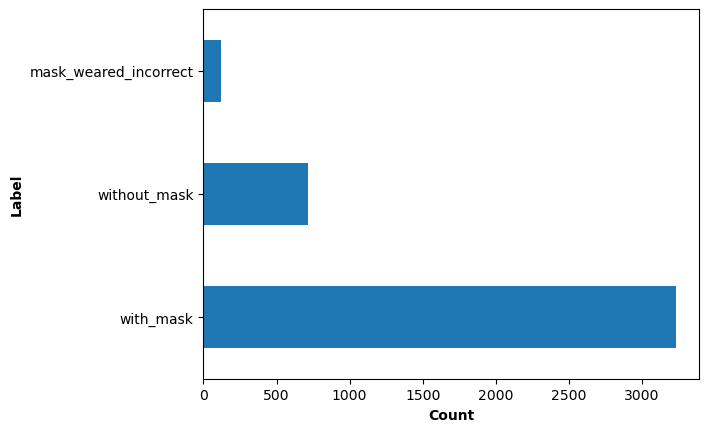

In [11]:
df["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')

#### As shown above, we have to deal with an unbalanced dataset. The appropriate solution for this kind of problem (where this distribution reflects the distribution in reality) is to split the data in a way that this distribution will be preserved in the train / test / validation sets. We can not apply Data balancing techniques like SMOTE, Data Oversampling, Data Undersampling as it will result in data manipulation.

# Prepare the data For CNN 

The next goal is to rearrange our data in new folders, according to their label. We first create an empty folder for each data set (train/ test/ validation) and for each of the 3 labels.

# FOR CNN

In [12]:
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)

Since each original image may contain multiple faces, we will need to crop all the faces from each image, based on the given coordinates, and copy them to the appropriate folder based on the label of each person. By that, we will recieve a dataset where each image consists of only one face + it's label. 

We will divide these steps into multiple functions. The following function will crop the image based on the given coordinates. We added a small shift (10% of the face size ) in both X and Y directions in order to include more data in each image. 

In [13]:
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):
    
    '''
     This function takes an image path + x and y coordinates of two opposite corners of the rectangle 
     and returns a cropped image
    '''
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

The next function extracts all the people from each image

In [14]:
def extract_faces(image_name, image_info):
    
    '''
     This function takes an image name + dataframe with information about the image 
     and splits the image into all the different faces. image name contains the 
     upper-left coordinate of each face so we could distinguish it later
    '''
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

We now apply the `extract_faces` function on our data set

In [15]:
cropped_faces = [extract_faces(img, df) for img in images]

Since the output of the `extract_faces` function is a list of lists, we need to flatten the cropped faces. i.e make it a list of images instead of a list of lists.

In [16]:
#flat_cropped_faces = [item for sublist in cropped_faces for item in sublist]
flat_cropped_faces = sum(cropped_faces, [])
#flat_cropped_faces

Sort the images into their labels according to our 3 classes. 

In [17]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

## len check

In [18]:
print(f'num of images with mask: {len(with_mask)}')
print(f'num of images without mask: {len(without_mask)}')
print(f'num of images incorrect mask: {len(mask_weared_incorrect)}')
print(f'sum: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

num of images with mask: 3231
num of images without mask: 715
num of images incorrect mask: 123
sum: 4069


We now split the full data set into train (80%) and test (20%) sets. The test set is split again to test (30%) and validation (70%) sets. 

In [19]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [20]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    '''
     This function takes an image name + a path of output folder
     and saves image into the output folder
    '''

    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)   

Save each image in the correct folder 

In [21]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')


In [22]:
# Defineing Some Constant Parameters
batch_size = 8
epochs = 100

## Augmention

In [23]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory=r'C:\Users\Ma548\Desktop\MVProject\WorkSpace\Programs\train',
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory=r'C:\Users\Ma548\Desktop\MVProject\WorkSpace\Programs\val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory=r'C:\Users\Ma548\Desktop\MVProject\WorkSpace\Programs\test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


## Custom Model

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_custom = Sequential()
model_custom.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model_custom.add(MaxPooling2D(pool_size = 2))
model_custom.add(Dropout(0.3))
model_custom.add(Flatten())
model_custom.add(Dense(units = 500, activation = 'relu'))
model_custom.add(Dropout(0.3))
model_custom.add(Dense(units = 3, activation = 'softmax'))


model_custom.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

### Plotting the model architecture

In [32]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [33]:
# Compiling the model
model_custom.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

# Early Stopping
# Before training the network, we define an early stopping criterion,
#to avoid redundent epochs once the model has already converged.
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Reduce Learning Rate On Plateau
# We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric
# we chose (`val_loss`) has stopped improving.
from keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [34]:
# Fit the model on train data

model_custom_history = model_custom.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[lrr]
)

model_custom.save('model_custom.h5')

Epoch 1/100


C:\Users\Ma548\AppData\Local\Temp\ipykernel_8436\3186064999.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_custom_history = model_custom.fit_generator(


50/50 [==============================] - 2s 18ms/step - loss: 0.6001 - accuracy: 0.8015 - recall: 0.7915 - precision: 0.8077 - auc: 0.9006 - val_loss: 0.4607 - val_accuracy: 0.7917 - val_recall: 0.7917 - val_precision: 0.7917 - val_auc: 0.9644 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 1s 11ms/step - loss: 0.5542 - accuracy: 0.7900 - recall: 0.7775 - precision: 0.8015 - auc: 0.9223 - val_loss: 0.4105 - val_accuracy: 0.8056 - val_recall: 0.8056 - val_precision: 0.8169 - val_auc: 0.9707 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 1s 12ms/step - loss: 0.3315 - accuracy: 0.8700 - recall: 0.8400 - precision: 0.9106 - auc: 0.9701 - val_loss: 0.2554 - val_accuracy: 0.9306 - val_recall: 0.9306 - val_precision: 0.9306 - val_auc: 0.9750 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 1s 11ms/step - loss: 0.3338 - accuracy: 0.8970 - recall: 0.8970 - precision: 0.9015 - auc: 0.9694 - val_loss: 0.2271 - val_accuracy: 0.9444 - val_recall

In [35]:
# Evaluate model performance on test data
model_custom_loss, model_custom_acc, custom_recall, custom_precision, custom_auc = model_custom.evaluate(test_generator)
print("Our Custom Model has a loss of %.2f and accuracy %.2f%%" % (model_custom_loss, model_custom_acc*100))
print("Our Custom Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (custom_recall*100, custom_precision*100, custom_auc*100))

31/31 [==============================] - 0s 5ms/step - loss: 0.1515 - accuracy: 0.9424 - recall: 0.9383 - precision: 0.9421 - auc: 0.9944
Our Custom Model has a loss of 0.15 and accuracy 94.24%
Our Custom Model has a recall of 93.83%, precision of 94.21% and auc of 99.44%


In [36]:
custom_predictions = model_custom.predict(test_generator)
print("predictions shape:", custom_predictions.shape)

31/31 [==============================] - 0s 5ms/step
predictions shape: (243, 3)


## Efficient Net - B0 (Transfer learning)

In [37]:
from keras.applications import EfficientNetB0
from keras.optimizers import Adam
import tensorflow as tf
# Create the EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96,96,3))

# Add the classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Combine the base model and classification head
model_effNet = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_effNet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy','Recall', 'Precision', 'AUC'])
model_effNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 96, 96, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 96, 96, 3)    0           ['normalization[0][0]']          
                                                                                              

In [41]:
# Fit Inception ion Train Data
model_effNet_history = model_effNet.fit(
    train_generator,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
)

Epoch 1/100
407/407 [==============================] - 11s 16ms/step - loss: 0.6240 - accuracy: 0.7926 - recall: 0.7876 - precision: 0.7933 - auc: 0.8783 - val_loss: 0.5504 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8194 - val_auc: 0.8715
Epoch 2/100
407/407 [==============================] - 5s 12ms/step - loss: 0.6163 - accuracy: 0.7941 - recall: 0.7938 - precision: 0.7940 - auc: 0.8805 - val_loss: 0.5578 - val_accuracy: 0.8472 - val_recall: 0.8472 - val_precision: 0.8472 - val_auc: 0.8958
Epoch 3/100
407/407 [==============================] - 5s 12ms/step - loss: 0.6076 - accuracy: 0.7941 - recall: 0.7941 - precision: 0.7941 - auc: 0.8840 - val_loss: 0.5791 - val_accuracy: 0.8056 - val_recall: 0.8056 - val_precision: 0.8056 - val_auc: 0.8920
Epoch 4/100
407/407 [==============================] - 5s 12ms/step - loss: 0.6123 - accuracy: 0.7941 - recall: 0.7941 - precision: 0.7941 - auc: 0.8792 - val_loss: 0.5188 - val_accuracy: 0.8056 - val_recall: 0.8056 - val_pre

In [42]:
model_effNet.save('model_effNet.h5')

In [43]:
# Evaluate model performance on test data
effNet_loss, effNet_acc, effNet_recall, effNet_precision, effNet_auc = model_effNet.evaluate(test_generator)
print("Efficient Net Model has a loss of %.2f and accuracy %.2f%%" % (effNet_loss, effNet_acc*100))
print("Efficient Net Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (effNet_recall*100, effNet_precision*100, effNet_auc*100))

31/31 [==============================] - 0s 10ms/step - loss: 0.5847 - accuracy: 0.7984 - recall: 0.7984 - precision: 0.7984 - auc: 0.8952
Efficient Net Model has a loss of 0.58 and accuracy 79.84%
Efficient Net Model has a recall of 79.84%, precision of 79.84% and auc of 89.52%


In [44]:
def plot_loss_and_accuracy(histories):
    fig, ax = plt.subplots(3,2, figsize=(12, 6))
    
    for i, history in enumerate(histories):
        history_df = pd.DataFrame(history)
        history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[i,0])
        ax[i,0].set(xlabel = 'epoch number', ylabel = 'loss')
        ax[i,0].set_title(f"Model {i+1} Loss")
        
        history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[i,1])
        ax[i,1].set(xlabel = 'epoch number', ylabel = 'accuracy')
        ax[i,1].set_title(f"Model {i+1} Accuracy")
        
    fig.tight_layout()
    plt.show()


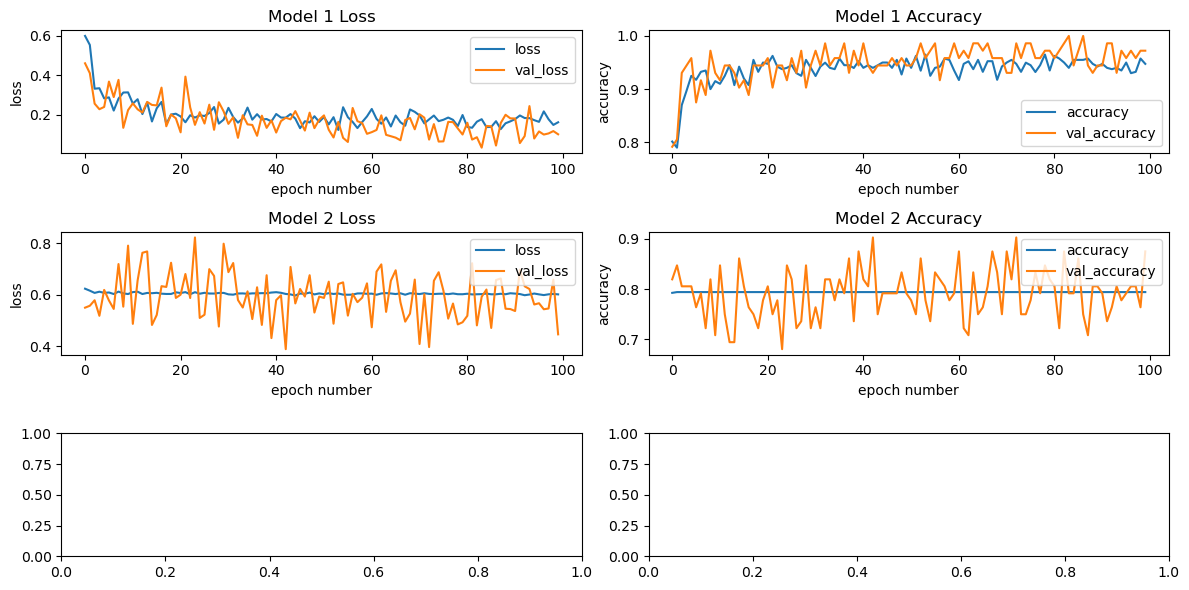

In [45]:
plot_loss_and_accuracy([model_custom_history.history, model_effNet_history.history])

### Randomly choose one image from the test set and examine the difference between the original labeling and the model prediction  

31/31 [==============================] - 0s 4ms/step
Class Predicted: with_mask , True label: with_mask\maksssksksss439_(171, 132).png for Custom Model


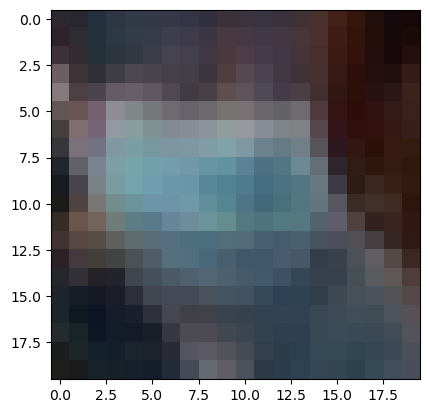

In [46]:
import cv2

paths = test_generator.filenames # Your files path

y_pred_custom = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred_custom[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label} for Custom Model')


31/31 [==============================] - 0s 4ms/step
Class Predicted: with_mask , True label: with_mask\maksssksksss439_(171, 132).png for Mobile Net Model


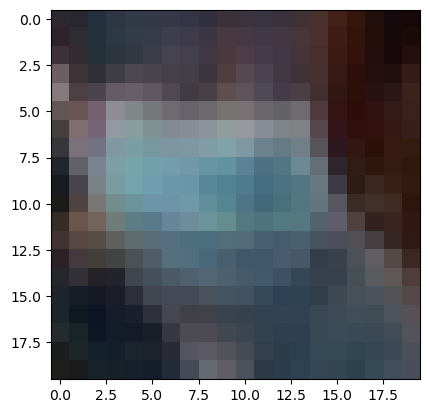

In [47]:
y_pred_MobileNet = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred_MobileNet[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label} for Mobile Net Model')


31/31 [==============================] - 0s 4ms/step
Class Predicted: with_mask , True label: with_mask\maksssksksss439_(171, 132).png for Efficient Net Model


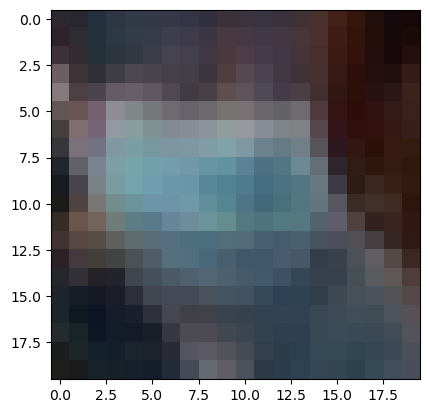

In [48]:
y_pred_EfficientNet = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred_EfficientNet[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label} for Efficient Net Model')


In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
def evaluate_models(true_labels, pred_labels1, pred_labels2, pred_labels3):
    fig, ax = plt.subplots(3,1, figsize=(12, 6))
    # Classification report for model 1
    print("Custom Model Classification Report:\n")
    print(classification_report(true_labels, pred_labels1))
    # Confusion matrix for model 1
    print("Custom Model Confusion Matrix:\n")
    cm1 = confusion_matrix(true_labels, pred_labels1)
    sns.heatmap(cm1,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20}, ax=axes[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Custom Model Confusion Matrix')

    # Classification report for model 2
    print("Efficient Model Classification Report:\n")
    print(classification_report(true_labels, pred_labels3))
    # Confusion matrix for model 2
    print("Efficient Model Confusion Matrix:\n")
    cm3 = confusion_matrix(true_labels, pred_labels3)
    sns.heatmap(cm3,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20}, ax=axes[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Efficient Model Confusion Matrix')

    
    
    plt.show()

In [50]:
y_true = test_generator.labels
y_pred_custom  = model_custom.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

# y_pred_mobileNet  = model_mobilenet.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

y_pred_EffNet  = model_effNet.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

# evaluate_models(y_true, y_pred_custom, y_pred_mobileNet, y_pred_EffNet)

31/31 [==============================] - 1s 10ms/step


In [51]:
# Use bincount() to count occurrences of each class in a predictions NumPy array
c_1, c_3 = np.bincount(y_pred_custom), np.bincount(y_pred_EffNet) 
# np.bincount(y_pred_mobileNet),
print(f'The Count of Occurences of Each Class in Each Model is Give below : ')
print(f'1. Custom Model : {c_1}')
# print(f'2. MobileNet Model : {c_2}')
print(f'3. EfficientNet Model : {c_3}')

The Count of Occurences of Each Class in Each Model is Give below : 
1. Custom Model : [  0 200  43]
3. EfficientNet Model : [  0 243]


# Testing the Results

1/1 [==============================] - 0s 9ms/step


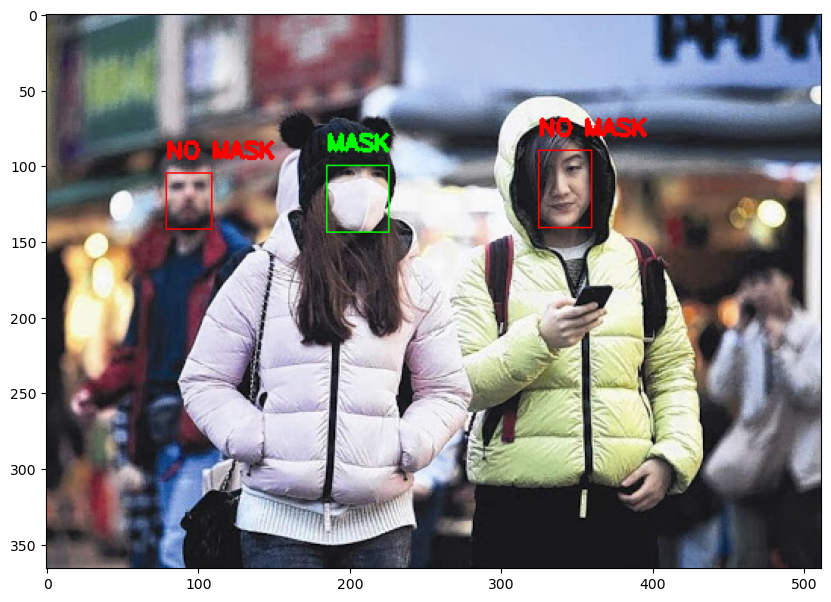

In [52]:
import cv2
img = cv2.imread(os.path.join(input_data_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]
#df_test_img
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model_custom.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)


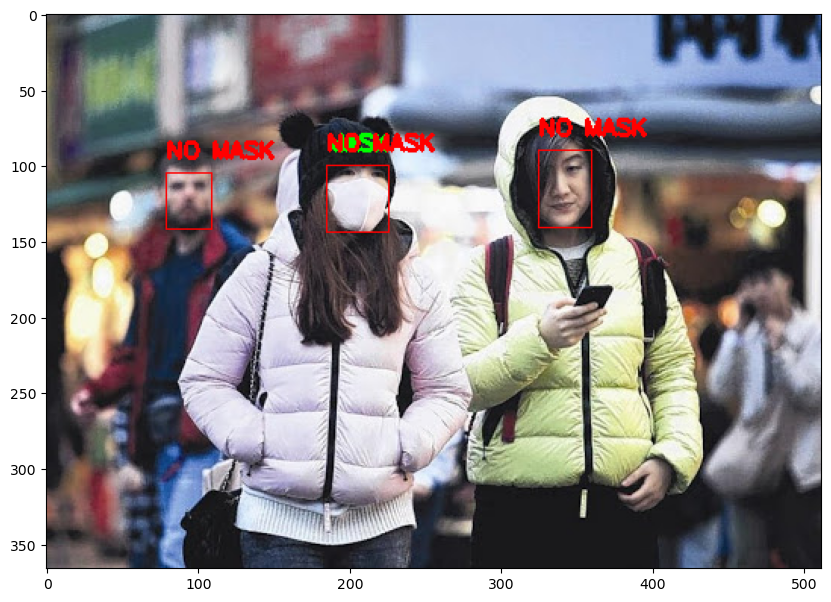

In [53]:
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(96,96))
    reshaped_face = np.reshape(resized_face,[1,96,96,3])/255.0

    # face_result = model_mobilenet.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)

1/1 [==============================] - 0s 21ms/step


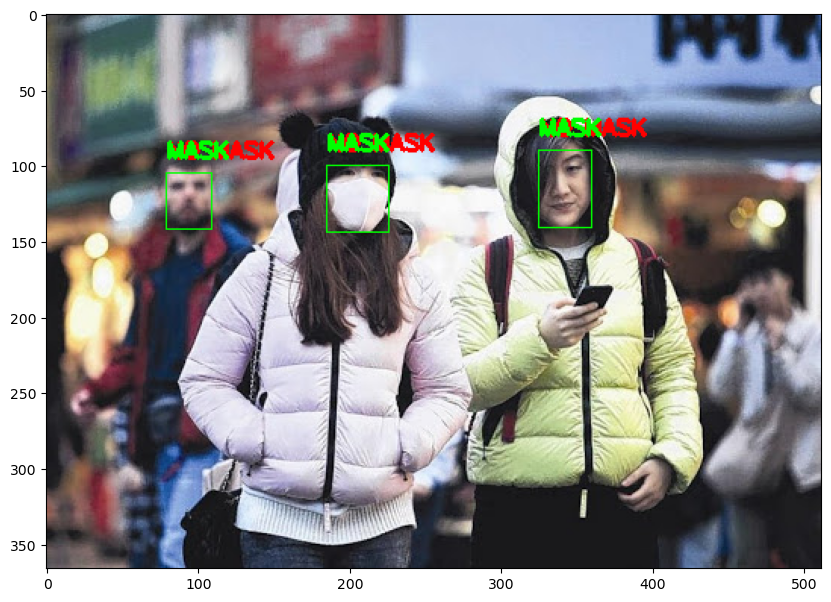

In [54]:
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(96,96))
    reshaped_face = np.reshape(resized_face,[1,96,96,3])/255.0

    face_result = model_effNet.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)